# Mean-Shift Clustering and Segmentation

In the first part of this task you will implement the *mean-shift* clustering algorithm in a general way (not specifically for anything to do with images, just simply for n-dimensional data points).

Then in the second part you will apply mean-shift for image segmentation, by clustering data points that represent pixels (e.g. the colors).

### Recap from the lecture
The *mean-shift* algorithm clusters an $n$-dimensional data set (i.e., each data point is described by a feature vector of $n$ values) by associating each point with a peak in the estimated probability density of the dataset's distribution. Points associated with the "same" peak (up to some small threshold) become members of the same cluster.

For each point, mean-shift finds the associated peak by first defining a spherical window of radius $r$ centered on that point, and computing the **mean** of the points that lie within the window. The algorithm then **shifts** the window to be centered on that mean and repeats these steps until convergence, i.e., until the shift is smaller than a specified threshold. At each iteration the window shifts to a more densely populated portion of the data set until a peak is reached, where the data is approximately equally distributed in the window.

In [1]:
%%html
<!-- Run this cell to add heading letters per subtask (like a, b, c) -->
<style>
body {counter-reset: section;}
h2:before {counter-increment: section;
           content: counter(section, lower-alpha) ") ";}
</style>

In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import time
import imageio
from mpl_toolkits.mplot3d import Axes3D
import cv2
import os



## Finding a peak from a query point
Implement the peak searching process as the function `find_peak(data, query, radius)` where

 * `data` is a $p \times n$ matrix containing $p$ data points; each point is defined by an $n$-dimensional row vector of feature values
 * `query` is the $n$-dimensional starting point from which we wish to compute a density peak
 * `radius` is the search window radius.

Return the peak as an $n$-dimensional vector.

**Hints:** You can use `np.linalg.norm` to compute the Euclidean norm of a vector. You can also index NumPy arrays with Boolean arrays, e.g. to select only rows that fulfil some criterion.

In [3]:
def find_peak(data, query, radius):
    # YOUR CODE HERE
    p,n=data.shape
    distance=np.zeros(p)
    for i in range(p):
        distance[i]=np.linalg.norm(np.transpose(np.array(query))-data[i,:],2)
    distance=(distance<radius)
    peak=np.mean(data[distance],axis=0)
    return peak
    #raise NotImplementedError()

We will now use the synthetic dataset `gaussian_mixture_samples_3d.csv` to test your implementation. The data points in this file are 2000 samples from two 3D Gaussian distributions. The following plots only show the projection on the XY plane.

(3,)


<IPython.core.display.Javascript object>


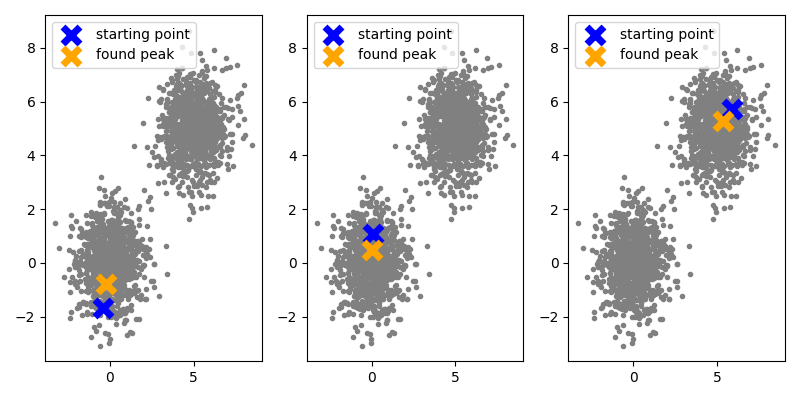

Found peak [-0.23987783 -0.77619915  0.03591038]
Found peak [0.03264388 0.4836916  0.08246612]
Found peak [5.38503083 5.26577746 4.78865915]


In [21]:
data = np.genfromtxt(f'gaussian_mixture_samples_3d.csv', delimiter=',')
query_ids = [0, 5, 1500]
x=np.transpose(np.array(query))
print(x.shape)
radius = 2

#fig, axes = plt.subplots(1, len(point_ids), figsize=(12,4))
fig, axes = plt.subplots(1, len(query_ids), figsize=(8,4))
for query_id, ax in zip(query_ids, axes):
    query = data[query_id]
    peak = find_peak(data, query, radius)
    print('Found peak', peak)
    
    ax.scatter(data[:, 0], data[:, 1], marker='.', color='gray')
    ax.scatter(query[0], query[1], s=150, linewidth=5,
               color='blue', marker='x', label='starting point')
    ax.scatter(peak[0], peak[1], color='orange', marker='x',
               s=150, linewidth=5, label='found peak')
    ax.legend()
fig.tight_layout()

## Clustering all points
Implement `mean_shift(data, radius)`, which calls `find_peak` for each point and then assigns a label to each point according to its peak.
`mean_shift` should return two arrays: `peaks` and `labels`.

  * `peaks` is a matrix with $k$ rows, storing the found density peaks, where $k$ is the data-dependent number of clusters found. 
  * `labels` is a $p$-sized vector that has an entry for each data point, storing its associated cluster label (an integer)

Similar peaks within a distance of `radius/2` should be considered the same and should be merged after each call to `find_peak`. More specifically, if the peak computed for a data point already exists in `peaks` (according to the distance threshold), then discard the newly computed peak and give the label of the already existing peak to the considered data point.

In [4]:
def mean_shift(data, radius):
    
    # YOUR CODE HERE
    p,n=data.shape
    peaks=[]
    labels = np.full(len(data), fill_value=-1, dtype=int)
    
    for i in range(p):
        peak=find_peak(data,data[i],radius)
        occur=0
        if len(peaks)==0:
            peaks.append(peak)
        else:
            for j in range(len(peaks)):
                # close enough to be considered as the same peak 
                if np.sqrt(np.linalg.norm(peak-peaks[j],2))<radius/2:
                    labels[i]=labels[j]
                    occur+=1
        if occur==0:
            peaks.append(peak)
            
    peaks=np.array(peaks) 
    
    #raise NotImplementedError()
    return peaks, labels

Now check the result of your implementation. The found peaks (cluster centers) are shown as black X marks. You can rotate the interactive 3D plots with the mouse (but it may be somewhat slow).

<IPython.core.display.Javascript object>


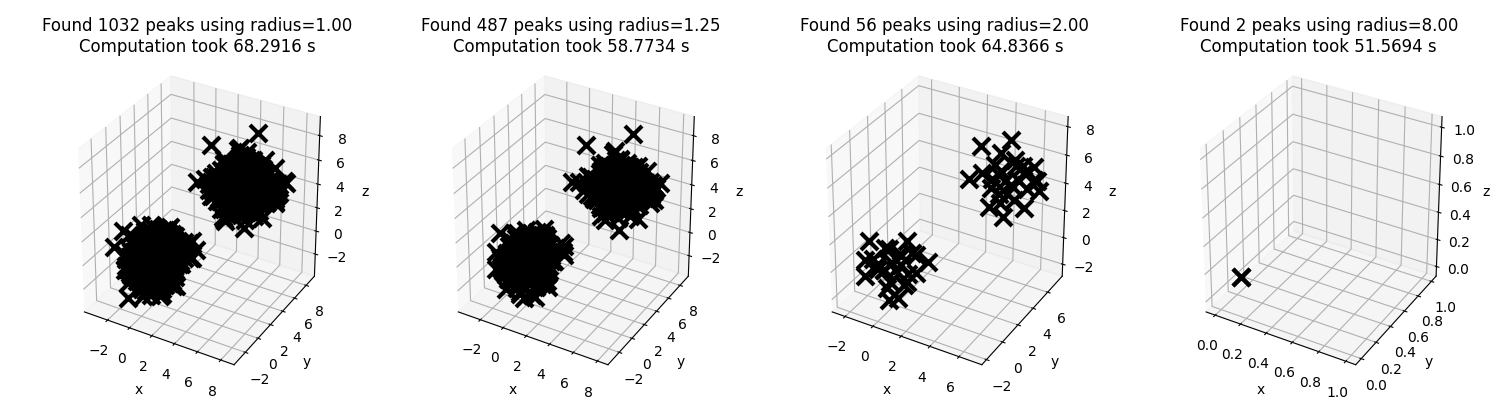

In [5]:
def plot_3d_clusters(ax, data, labels, peaks, 
                     peak_colors=None, colors=None, axis_names='xyz'):
    """Plots a set of point clusters in 3D, each with different color."""

    def luv2rgb(color):
        expanded = color[np.newaxis, np.newaxis]
        rgb = cv2.cvtColor(expanded.astype(np.uint8), cv2.COLOR_LUV2RGB)
        return rgb[0,0]/255
      
    if peak_colors is None:
        peak_colors = peaks
    
    for label in range(len(peaks)):
        if colors=='rgb':
            cluster_color = color = peak_colors[label]/255
        elif colors=='luv':
            cluster_color = luv2rgb(peak_colors[label])
        else:
            cluster_color=None

        cluster = data[labels==label]
        ax.scatter(cluster[:, 0], cluster[:, 1], cluster[:, 2],
                   alpha=0.15, color=cluster_color)
        ax.scatter(peaks[label, 0], peaks[label, 1], peaks[label, 2], 
                   color='black', marker='x', s=150, linewidth=3)

    ax.set_xlabel(axis_names[0])
    ax.set_ylabel(axis_names[1])
    ax.set_zlabel(axis_names[2])

data = np.genfromtxt(f'gaussian_mixture_samples_3d.csv', delimiter=',')
radii = [1, 1.25, 2, 8]
#radii = [5,5,5,5]
fig, axes = plt.subplots(
    1, len(radii), figsize=(15,4), subplot_kw={'projection': '3d'})

for radius, ax in zip(radii, axes): 
    start_time = time.time()
    peaks, labels = mean_shift(data, radius)
    #print(peaks.shape)
    #print(labels.shape)
    plot_3d_clusters(ax, data, labels, peaks)
    duration = time.time()-start_time
    ax.set_title(
        f'Found {len(peaks)} peaks using radius={radius:.2f}\n'
        f'Computation took {duration:.4f} s\n')
    
fig.tight_layout()

## Speedups

As described so far, the mean-shift algorithm is too slow to be used for image segmentation where each data point corresponds to a pixel, there are just too many pixels in normal sized images. Therefore, you should incorporate the following two speedups from the lecture into your implementation. 

**First speedup**: upon finding a new peak, associate each data point within `radius` distance from that peak with the cluster defined by that peak. This speedup is known as the *“basin of attraction”* and is based on the intuition that points within one window size distance from the peak will, with high probability, converge to that peak.

Call the new function `mean_shift_opt`.

In [6]:
def mean_shift_opt(data, radius):
    labels = np.full(len(data), fill_value=-1, dtype=int)
    
    # YOUR CODE HERE
    p,n=data.shape
    peaks=[]
    label=0
    while np.any(np.nonzero(labels==-1)):
        
        query_point_index=np.nonzero(labels==-1)[0][0]
        query=data[query_point_index]
        peak=find_peak(data,query,radius)
        for i in range(p):
            if np.sqrt(np.linalg.norm(data[i]-peak,2))<radius:
                labels[i]=label
        label=label+1
        peaks.append(peak)
        
    peaks=np.array(peaks)
    
    return peaks, labels

Now run the code to check the result.

In [7]:
data = np.genfromtxt(f'gaussian_mixture_samples_3d.csv', delimiter=',')
radii = [1, 1.25, 2, 8]
fig, axes = plt.subplots(
    1, len(radii), figsize=(15,4), subplot_kw={'projection': '3d'})

for radius, ax in zip(radii, axes): 
    start_time = time.time()
    peaks, labels = mean_shift_opt(data, radius)
    plot_3d_clusters(ax, data, labels, peaks)
    duration = time.time()-start_time
    ax.set_title(
        f'Found {len(peaks)} peaks using radius={radius:.2f}\n'
        f'Computation took {duration:.4f} s\n')
    
fig.tight_layout()

<IPython.core.display.Javascript object>

The **second speedup** is based on a similar principle: Associate points within a distance $\mathtt{radius}/c$ of the search path with the converged peak ($c$ is some constant value). Use $c = 3$ for this assignment.

To realize this speedup, you will need to modify `find_peak` into `find_peak_opt`, which returns two values: `peak` and `is_near_search_path`. The latter should be a Boolean output vector of length $p$ (number of data points) containing `True` for each point that we encountered within a distance $\mathtt{radius}/c$ on our search path, and `False` for the others. Then use this Boolean vector in a new version of `mean_shift_opt`, called `mean_shift_opt2` to do the label assignments accordingly.

In [8]:
def find_peak_opt(data, query, radius, c=3):
    is_near_search_path = np.zeros(len(data), dtype=bool)
    
    # YOUR CODE HERE
    p,n=data.shape
    distance=np.zeros(p)
    for i in range(p):
        distance[i]=np.linalg.norm(np.transpose(np.array(query))-data[i,:],2)
    is_near_search_path=(distance<(radius/c))
    peak=np.mean(data[is_near_search_path],axis=0)
    return peak,is_near_search_path
    #raise NotImplementedError()

def mean_shift_opt2(data, radius):
    
    labels = np.full(len(data), fill_value=-1, dtype=int)
    # YOUR CODE HERE
    peaks=[]
    p,n=data.shape
    for i in range(p):
        peak,is_near_search_path=find_peak_opt(data,data[i],radius,c=3)
        peaks.append(peak)
        if is_near_search_path[i]==True:
            labels[i]=np.max(labels[i])+1
    
    peaks=np.array(peaks)
    #raise NotImplementedError()
    
    return peaks, labels

data = np.genfromtxt(f'gaussian_mixture_samples_3d.csv', delimiter=',')
radii = [1, 1.25, 2, 8]
fig, axes = plt.subplots(
    1, len(radii), figsize=(15,4), subplot_kw={'projection': '3d'})

for radius, ax in zip(radii, axes):
    start_time = time.time()
    peaks, labels = mean_shift_opt2(data, radius)
    print(type(peaks))
    #print(type(labels))
    plot_3d_clusters(ax, data, labels, peaks)
    duration = time.time()-start_time
    ax.set_title(f'Found {len(peaks)} peaks using radius={radius:.2f}\n'
                 f'Computation took {duration:.4f} s\n')
    
fig.tight_layout()

<IPython.core.display.Javascript object>

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


## Questions

1. Which radius gives good results and how would you choose it in general?
2. How much faster is the optimized version?
3. Can the speedups change the result? If yes, did it get worse in this particular case?

YOUR ANSWER HERE:
1. Radius=2.5 is a good result
2. more than 1000 times faster
3. yes it can, and the result is even better.

## Image Segmentation by Mean-Shift

Now use your mean-shift implementation from above to segment images. Note that although very efficient mean-shift implementations exist, our version here may take several minutes per image. Debug using small images.

Implement the function `mean_shift_segment(im, radius)` where `im` is an input RGB image of shape $\mathtt{height}\times\mathtt{width}\times 3$ and `radius` is the parameter associated with the mean-shift algorithm. The output should be `data`, `peaks`, `labels`, `segmented_image`:

* `data` is the array of the data points that you input to the mean-shift algorithm, with $p$ rows and 3 columns.
* `peaks` and `labels` are simply the results returned by the `mean_shift` call (without changing them).
* The `segmented_image` is constructed by assigning to each pixel the color value of the corresponding cluster's peak.

You will need to reshape (`np.reshape`) the image array before feeding it to your mean-shift clustering function. Also, do not forget to convert the pixel values to floating point, using `somearray.astype(float)` and then convert the result back to 8-bit unsigned integers using `somearray.astype(np.uint8)`.

Segment the image `terrain_small.png` using `radius` 15.

In [9]:
def mean_shift_segment(im, radius):
    # YOUR CODE HERE
    #print(im.shape)
    h,w,c=im.shape
    data=np.reshape(im,newshape=(h*w,c))
    data.astype(float)
    peaks,labels=mean_shift(data,radius)
    peaks.astype(np.uint8)
    labels.astype(np.uint8)
    
    segmented_im=np.reshape(labels,newshape=(h,w))
    #raise NotImplementedError()
    return data, peaks, labels, segmented_im

In [ ]:
def make_label_colormap():
    """Create a color map for visualizing the labels themselves,
    such that the segment boundaries become more visible, unlike
    in the visualization using the cluster peak colors.
    """
    import matplotlib.colors
    rng = np.random.RandomState(2)
    values = np.linspace(0, 1, 20)
    colors = plt.cm.get_cmap('hsv')(values)
    rng.shuffle(colors)
    return matplotlib.colors.ListedColormap(colors)

label_cmap = make_label_colormap()

im = imageio.imread('terrain.png')
start_time = time.time()
data, peaks, labels, segmented_im = mean_shift_segment(im, radius=15)
print(labels.shape)
duration= time.time()-start_time
print(f'Took {duration:.2f} s')

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(2, 2, 1)
ax.set_title('Original Image')
ax.imshow(im)

ax = fig.add_subplot(2, 2, 2)
ax.set_title('Segmented')
ax.imshow(segmented_im)

ax = fig.add_subplot(2, 2, 3)
ax.set_title('Labels')
ax.imshow(labels.reshape(im.shape[:2]), cmap=label_cmap)

ax = fig.add_subplot(2, 2, 4, projection='3d')
ax.set_title(f'RGB space')
plot_3d_clusters(ax, data, labels, peaks, colors='rgb', axis_names='RGB')
fig.tight_layout()

## Segmentation in LUV color space
Note that mean-shift uses the Euclidean distance metric. Unfortunately, the Euclidean distance in RGB color space does not correlate well to color difference as perceived by people. For example in the green portion of RGB space, large distances are perceived as the roughly same color, whereas in the blue part a small RGB-distance may cause a large change in perceived color. For this reason we will now use the non-linear LUV color space, where the Euclidean distance better models the perceived difference in color.

In the function `mean_shift_segment_luv(...)` cluster the image data in LUV color space by first converting the RGB color vectors to LUV using OpenCV: `cv2.cvtColor(rgb_image, cv2.COLOR_RGB2LUV)`. Then convert the resulting cluster centers back to RGB using `cv2.cvtColor(luv_image, cv2.COLOR_LUV2RGB)`.

If we want to include spatial *position information* in the feature vectors as well, we can make the feature vectors 5 dimensional by specifying in addition to the the L, U, and V values also the x, and y coordinates of each pixel. Write a function `mean_shift_segment_luv_pos(im, radius)` that does this. **Hint:** useful functions are `np.arange`, `np.meshgrid`, `np.concatenate`, `np.expand_dims`).

In [17]:
def mean_shift_segment_luv(im, radius):
    # YOUR CODE HERE
    im=cv2.cvtColor(im,cv2.COLOR_RGB2LUV)
    data, peaks, labels, segmented_im=mean_shift_segment(im, radius)
    cv2.cvtColor(segmented_im,cv2.COLOR_LUV2RGB)
    #raise NotImplementedError()
    return data, peaks, labels, segmented_im
    
def mean_shift_segment_luv_pos(im, radius, pos_factor=1):
    # YOUR CODE HERE
    #raise NotImplementedError()
    im=cv2.cvtColor(im,cv2.COLOR_RGB2LUV)
    for i in range(im.shape[0]):
        for j in range(im.shape[[1]]):
            np.concatenate((im[i][j],i),axis=0)
            np.concatenate((im[i][j],j),axis=0)
    data, peaks, labels, segmented_im=mean_shift_segment(im, radius)
    cv2.cvtColor(segmented_im,cv2.COLOR_LUV2RGB)
    
    return data, peaks, labels, segmented_im

In [18]:
im = imageio.imread('terrain_small.png')
data, peaks, labels, segmented_im = mean_shift_segment_luv(im, radius=10)
fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(2, 3, 1)
ax.set_title('Segmented (LUV)')
ax.imshow(segmented_im)

ax = fig.add_subplot(2, 3, 2)
ax.set_title('Labels (LUV)')
ax.imshow(labels.reshape(im.shape[:2]), cmap=label_cmap)

ax = fig.add_subplot(2, 3, 3, projection='3d')
ax.set_title(f'LUV space')
plot_3d_clusters(ax, data, labels, peaks, colors='luv', axis_names='LUV')

data, peaks, labels, segmented_im = mean_shift_segment_luv_pos(im, radius=20)
ax = fig.add_subplot(2, 3, 4)
ax.set_title('Segmented (LUV+pos)')
ax.imshow(segmented_im)

ax = fig.add_subplot(2, 3, 5)
ax.set_title('Labels (LUV+pos)')
ax.imshow(labels.reshape(im.shape[:2]), cmap=label_cmap)

ax = fig.add_subplot(2, 3, 6, projection='3d')
ax.set_title(f'VXY space')
plot_3d_clusters(
    ax, data[:, 2:], labels, peaks[:, 2:], 
    peak_colors=peaks[:, :3], colors='luv', axis_names='VXY')
ax.invert_zaxis()
ax.view_init(azim=20, elev=15)

fig.tight_layout()

error: OpenCV(4.2.0) /Users/travis/build/skvark/opencv-python/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::(anonymous namespace)::CvtHelper<cv::impl::(anonymous namespace)::Set<3, -1, -1>, cv::impl::(anonymous namespace)::Set<3, 4, -1>, cv::impl::(anonymous namespace)::Set<0, 5, -1>, cv::impl::(anonymous namespace)::SizePolicy::NONE>::CvtHelper(cv::InputArray, cv::OutputArray, int) [VScn = cv::impl::(anonymous namespace)::Set<3, -1, -1>, VDcn = cv::impl::(anonymous namespace)::Set<3, 4, -1>, VDepth = cv::impl::(anonymous namespace)::Set<0, 5, -1>, sizePolicy = cv::impl::(anonymous namespace)::SizePolicy::NONE]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


## Experiment with the parameters

How does the `radius` and the choice of the feature vector affect the resulting segmentations? What effect does adding position information have? What are the advantages and disadvantages of using each type of feature vector? Can you suggest any extensions that might avoid many of the situations where single regions are over-segmented into multiple regions?

YOUR ANSWER HERE

In [ ]:
radii = [5, 10, 20]
fig, axes = plt.subplots(len(radii), 3, figsize=(15, 15))
for radius, ax in zip(radii, axes):
    segmented_im = mean_shift_segment(im, radius)[-1]
    ax[0].imshow(segmented_im)
    ax[0].set_title(f'Radius {radius} RGB')
    
    segmented_im = mean_shift_segment_luv(im, radius)[-1]
    ax[1].imshow(segmented_im)
    ax[1].set_title(f'Radius {radius} LUV')

    segmented_im = mean_shift_segment_luv_pos(im, radius)[-1]
    ax[2].imshow(segmented_im)
    ax[2].set_title(f'Radius {radius} LUV+pos')
fig.tight_layout()

## [BONUS] Test it on a larger image

Run your algorithm on at least one larger (approx. 300x200) test image using your own choice of `radius` and feature vector definition. One source for possible test images is the dataset of images available at http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/segbench/. You can also try the example images included in the scikit-image library, e.g. `import skimage.data; im = skimage.data.astronaut()`. Or any image from anywhere.

Processing can take several minutes for larger images.

In [ ]:
import skimage.data
im = skimage.data.astronaut()
im = cv2.resize(im, (256,256))

# YOUR CODE HERE
raise NotImplementedError()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].set_title('Original image')
axes[0].imshow(im)
axes[1].set_title('Segmented image')
axes[1].imshow(segmented_im)
axes[2].set_title('Labels')
axes[2].imshow(labels.reshape(im.shape[:2]), cmap=label_cmap)
fig.tight_layout()

## [BONUS++] Efficient Implementation

Mean-shift is highly parallelizable and GPU-based implementations can be many times faster for such workloads.
If you already know TensorFlow or CUDA, you can try implementing mean-shift for the GPU.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()